This page is a tutorial on how to solve the inverse heat conduction problem (IHCP) with Python code. It is mostly based on [this series of articles](http://www.techniques-ingenieur.fr/base-documentaire/energies-th4/transferts-thermiques-42214210/problemes-inverses-en-diffusion-thermique-be8266/) (in French) that give a great introduction to inverse problems in heat transfer.

## Introduction

The physical problem is 1D transient heat flow in a finite wall:

<img src='figures/mat_ihcp1.png' width=250 />


The problem is one-dimensional heat conduction inside a wall of thermal conductivity $\lambda$ and thickness $e$. One boundary is subjected to a heat flow $u$ while the other boundary is either insulated ($h=0$) or open ($h>0$). A temperature sensor is placed at a certain location $x_s$ within the medium. The initial temperature is uniform $T_0 = 0^{\circ}C$.

If the heat input $u$ and the material properties are known, calculating the evolution of temperature is straightforward, and may even have an exact analytical solution under some assumptions. On the opposite, the **inverse** heat conduction problem is the estimation of the time-varying boundary heat flow from noisy temperature measurements.

<img src='figures/mat_ihcp2.png' width=700 />

The input to the inverse problem are measurements of temperature, which may have been recorded anywhere within the wall (see left panel of the figure above). The target is to reconstruct the history of the heat flow on the left boundary of the wall (see right panel of the figure above). We assume that the thermal conductivity $\lambda$ and sensor position $x_s$ are known.

Since the heat flow is a function of time, the trick to make it identifiable by the inverse problem is to parameterise it into a finite set of $n$ elementary functions $f_j$:
\begin{equation}
u\left(t\right) = \sum_{j=1}^{n}{u_j f_j(t)}
\end{equation}
Hence, the problem actually has $n$ unknowns, assembled into a vector **u** = [$u_j; j \in \{1...n\}$]. The proper choice for the number of elementary functions is not really the topic of this tutorial, although it is [an important issue](http://www.techniques-ingenieur.fr/base-documentaire/energies-th4/transferts-thermiques-42214210/problemes-inverses-en-diffusion-thermique-be8266/).

## Background

### Model
The physical model is the 1D heat conduction equation in a finite medium of heat capacity $\rho c_p$ and conductivity $\lambda$:

\begin{align}
\rho c_p \frac{\partial T}{\partial t} = \lambda \frac{ \partial^2 T}{\partial x^2}
\end{align}

Assorted with the following boundary conditions: a prescribed heat flow $u(t)$ on the left boundary and a type-3 condition ($h$, $T_\infty$) on the right boundary

\begin{align}
-\lambda \dfrac{\partial T}{\partial x} & = u\left(t\right) & \quad \mathrm{if} \quad x = 0 \\
-\lambda \dfrac{\partial T}{\partial x} & = h \left(T-T_\infty\right) & \quad \mathrm{if} \quad x = e
\end{align}

### Discretisation
In order to solve the conservation equation by the finite difference method, the medium is discretised into $N$ equally spaced nodes. The temperature at each node may be assembled into a matrix:
$ \mathbf{T} = \left[T_1(t) \; T_2(t) \; ... \; T_N(t) \right] $ ;
where the time is also discretised: $t \in \{t_0, t_1... t_k, t_{k+1}... t_K\}$. The size of the entire temperature matrix of the problem is then [$K \times N$].

This discretisation allows summarizing the conservation equation
\begin{equation}
\frac{\mathrm{d} \mathbf{T}}{\mathrm{d} t} = \mathbf{A} \mathbf{T} + \mathbf{b}u\left(t\right)
\end{equation}
with the **A** and **b** matrices defined as follows

\begin{align}
\mathbf{A} & = \frac{a}{\Delta x^2}
\left[ \begin{array}{ccccc}
-2 & 2 & 0 & ... & 0 \\
1 & -2 & 1 & & 0 \\
0 & & & & \\
... & & 1 & -2 & 1 \\
0 & ... & 0 & 2 & -2\left(1+\mathrm{Bi}\right) \\
\end{array} \right]
\end{align}

\begin{align}
\mathbf{b} & = \frac{2}{\rho c_p \Delta x}
\left[ \begin{array}{c}
1 \\
0 \\
... \\
0 \\
\end{array} \right]
\end{align}

where $a=\lambda / \rho c_p$ is the thermal diffusivity and Bi=$h\Delta x/\lambda$ is the Biot number.

### Inverse problem: solving $u$ from $T$
The temperature is not known through the entire wall, but only at a specific sensor position $x_s$. Knowing the vector of temperature measurements on this spot $\mathbf{T}_\mathrm{obs}$ (size [$K \times 1$]), the heat flow $u(t)$ may be computed by inversing the linear system of equations:

\begin{equation}
\mathbf{T}_\mathrm{obs} = \mathbf{T}(x_s,t) = \mathbf{S} \; \mathbf{u}
\end{equation}

where **S** is the sensitivity matrix of size [$K \times n$]:

\begin{equation}
S_{kj} = \mathbf{C} \int_{t_0}^{t_k}{\exp\left[\mathbf{A}\left(t_k-\tau\right)\right]\mathbf{b}f_j\left(\tau\right)\mathrm{d}\tau}
\end{equation}

Note that this is only valid in the specific conditions $\mathbf{T}(t_0)=T_\infty=0^\circ$C. In this expression, the vector **C** (size [$1 \times N$]) points to the sensor position within the grid (its only non-zero value is at the position of the sensor $x_s$ in the space discretisation):

\begin{equation}
\mathbf{C} = \left[0 \; 0 \; ... \; 1 \; ... \; 0 \right]
\end{equation}

Since the sensitivity matrix is certainly not square (unless we are doing something wrong), the inversion of the linear system yields the final expression for the heat flow:
\begin{equation}
\mathbf{u} = \left[\left(\mathbf{S}^T\mathbf{S}\right)^{-1}\mathbf{S}^T \right] \mathbf{T}_\mathrm{obs}
\end{equation}
And that's it for the math. Now let's look at some code.

##  Python code

### Physical specifications
Let's start with generic conditions of the problem: the space discretisation, material properties, initial and boundary conditions.

In [1]:
import numpy as np

# Space discretisation
N = 21                  # number of nodes in the mesh
delta_x = 0.05 / (N-1)  # spacing between nodes

# Material properties
lambda_ = 0.3           # heat conductivity
rho_cp  = 1.2e6         # heat capacity
a = lambda_ / rho_cp    # heat diffusivity

# Initial and boundary conditions
h = 0                   # surface transfer coefficient on the right boundary
T_initial = 0           # initial temperature
Biot = h * delta_x / lambda_

### Input data
Measurements are provided in a separate .txt file (available in the repository).

In [2]:
import pandas
data_ = pandas.read_csv('data/ihcp_data.txt', delimiter='\t')
time_ = np.array(data_['t (s)'])    # time discretisation
K     = len(time_)                  # number of time steps

The main input to the inverse problem are the temperature measurements. In order to make things more interesting, we decide to add some measurement noise in the form of a normal random component of fixed standard deviation. Studying the influence of this noise on the accuracy of the solution is quite interesting, and you may do exactly that with this code.

In [3]:
T_obs  = np.array(data_['T(e/2)'])
T_obs += np.random.normal(0, 0.2, size=np.size(T_obs))

We just chose the temperature recorded in the middle of the wall `T(e/2)` as the input to the inverse problem. Hence, the **C** matrix involved in the sensitivity matrix must be defined accordingly:

In [4]:
C = np.zeros(N)
C[10] = 1

### Setting up the system

In building the system of linear equations, let us start with the A and b matrices defined above:

In [5]:
diag_moy = -2*np.ones(N)
diag_sup = np.ones(N-1)
diag_inf = np.ones(N-1)
diag_moy[-1] += -2*Biot
diag_sup[0]  += 1
diag_inf[-1] += 1
A = a / delta_x**2 * (np.diag(diag_moy)+np.diag(diag_inf, k=-1)+np.diag(diag_sup, k=1))
b = np.zeros(N)
b[0] += 2./(rho_cp * delta_x)

Next, let's define the elementary functions $f_j$ that are used to parameterise **u** into a finite number of unknowns. I chose [hat functions](https://en.wikipedia.org/wiki/Triangular_function) because why not.

In [6]:
n = 20                                  # number of modes for the discretisation of u
time_n = np.linspace(0, time_[-1], n)   # time discretisation of u

def f_hat(t, j, time_n):
    """
    Hat function #j defined on a time grid t_vector
    t: global time scale
    time_n: time scale of the discretisation for u
    j: position of the f_hat function on the t_vector scale (1 <= j <= n)
    """
    
    delta_t = np.diff(time_n).mean()
    
    f_rise = (t-time_n[j-1]) / delta_t
    f_decr = 1 - (t-time_n[j]) / delta_t
    
    if j == 0:
        is_rise = False
    else:
        is_rise = (t >= time_n[j-1]) * (t <= time_n[j])
        
    if j == len(time_n)-1:
        is_decr = False
    else:
        is_decr = (t >= time_n[j]) * (t <= time_n[j+1])
    
    return f_rise * is_rise + f_decr * is_decr

The last step, and not the least, into building the equation system, is to write the sensitivity matrix.

In [7]:
# The initial time t0 doesnt appear in S, so the matrix has one less line
S = np.zeros((K-1, n-1))
from scipy.linalg import expm
time_indices = range(K)
for t in time_indices[1:]:
    
    tau   = time_[:t+1]
    
    for j in range(n-1):
        
        f_tau = f_hat(tau, j, time_n)
        # Calculate an integral for each value of S
        foo = np.zeros(len(tau))
        for i in range(len(tau)):
            # This is a scalar
            foo[i] = np.dot(C, np.dot( expm(A*(time_[t]-tau[i])), b)) * f_tau[i]
        S[t-1,j] = np.trapz(foo, tau)

### Solving
The system is now defined, and the last thing to do is to solve it. The vector **u** is found directly by (sort of) inversing the sensitivity matrix:

In [8]:
u_modes = np.linalg.solve(np.dot(S.T, S), np.dot(S.T, T_obs[1:]))

And finally, the actual value of the heat flow is found by going through the elementary functions $f_j$ again:

In [9]:
u = np.zeros(K)
for j in range(n-1):
    u += u_modes[j] * f_hat(time_, j, time_n)

Our work here is done. We may now compare our results with the target value of the heat flow.

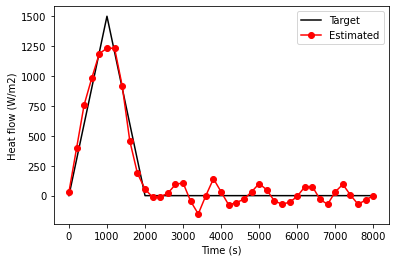

In [10]:
u_true = data_['U (W/m2)']

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(time_, u_true, '-k')
plt.plot(time_, u, 'or-')

plt.xlabel('Time (s)')
plt.ylabel('Heat flow (W/m2)')
plt.legend(('Target', 'Estimated'))
plt.show()

As far as real-world inverse problems go, this is a pretty good estimate. An interesting study would now be to look at the influence of a few hypotheses on the quality of the estimation of **u**:
* the magnitude of the noise;
* the number of modes $n$ versus the measurement sampling time $K$;
* the position of the sensor...
Should such difficulties add up and compromise the accuracy of the identification, regularisation may quickly become essential.